# 用Scikit-Learn实现常用分类器（Fashion MNIST）


## 一、引入相关库
   在进行计算机视觉编程的时候，我们需要在__向量、矩阵__的表示上进行操作，这可以通过__NumPy__ 模块处理；在该模块中，向量和矩阵是用array 类型表示的，对于图像，也可以采用这种类型的表示。

   我们处理__数学运算、绘制图表__，或者在图像上绘制__点、直线和曲线__时，__Matplotlib__ 是个很好的类库，具有比 PIL 更强大的绘图功能。 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 将matplotlib 的图表直接嵌入到notebook 之中
%matplotlib inline

# 使用参数字典(rcParams)设置matplotlib.pyplot的默认值
plt.rcParams['figure.figsize'] = (15., 12.) # 设置图像大小
plt.rcParams['image.interpolation'] = 'nearest'# 设置interpolation style
plt.rcParams['image.cmap'] = 'gray'# 设置为灰度图像

# 每次执行新行之前重新加载所有已更改的模块
%load_ext autoreload
%autoreload 2

## 二、数据加载
__Fashion-MNIST__ 是一个替代MNIST手写数字集的图像数据集，其原始大小为60000/10000的训练测试数据划分。这里为了方便起见重新划分了数据集，训练集/验证集/测试集划分：__6000/500/500__（验证集从测试集中划分）。

数据引入方式参考Fashion-MNIST 的Github项目地址https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md 从该地址下载数据集和mnist_reader.py 可以实现快速引入数据。

__sklearn__ 是一个Python第三方提供的非常强力的机器学习库，它包含了从数据预处理到训练模型的各个方面。在实战使用scikit-learn中可以极大的节省我们编写代码的时间以及减少我们的代码量，使我们有更多的精力去分析数据分布，调整模型和修改超参。

本段代码使用sklearn 的__train_test_split__ 来划分数据，它的功能是从样本中随机的按比例选取train_data和test_data，形式为：
>X_train,X_test, y_train, y_test = train_test_split(train_data,train_target,test_size, random_state)

参数解释：
- train_data：所要划分的样本特征集
- train_target：所要划分的样本结果
- test_size：样本占比，如果是整数的话就是样本的数量
- random_state：是随机数的种子。随机数种子其实就是该组随机数的编号，在需要重复试验的时候，保证得到一组一样的随机数。比如每次都填1，其他参数一样的情况下得到的随机数组是一样的。但填0或不填，每次都会不一样。

数据预处理 __标准化（Standardization or Mean Removal and Variance Scaling)__ ，通过sklearn的 __preprocessing模块__ ,变换后各维特征有0均值，单位方差。也叫 __z-score规范化（零均值规范化）__ 。计算方式是将 __特征值减去均值，除以标准差__ 。一般会在训练集上做标准化后，用同样的标准化器去标准化验证集和测试集，此时可以用 __scaler__ 。

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
import mnist_reader

#引入数据
X_train, y_train = mnist_reader.load_mnist('data', kind='train')
X_test, y_test = mnist_reader.load_mnist('data', kind='t10k')
print("原始数据集大小（训练/测试）")
print(X_train.shape)
print(X_test.shape)

#利用train_test_split将测试集按1:1划分为测试集和验证集
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=22)

#缩小数据集的规模6000:500:500
X_train,X,y_train,y = train_test_split(X_train,y_train,test_size=0.9,random_state=22)
X_val,X,y_val,y = train_test_split(X_val,y_val,test_size=0.9,random_state=22)
X_test,X,y_test,y = train_test_split(X_test,y_test,test_size=0.9,random_state=22)

print("划分后的数据集大小（训练/验证/测试）")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

# 预处理: 标准化
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


原始数据集大小（训练/测试）
(60000, 784)
(10000, 784)
划分后的数据集大小（训练/验证/测试）
(6000, 784)
(500, 784)
(500, 784)


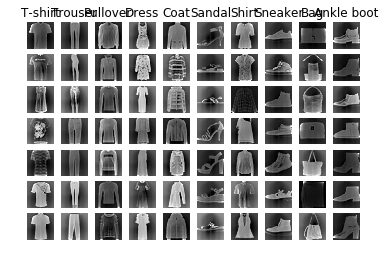

In [4]:
# 在测试集上每个类别随机显示7张图像
# Fashion MNIST共有以下10个标签
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(28,28))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## 三、构造分类器并进行训练
借助scikit-learn算法包快速实现

### 1. 实现KNN分类器
在分类方法中，最简单且用得最多的一种方法之一就是__KNN（K-Nearest Neighbor ,K邻近分类法）__，这种算法把要分类的对象（例如一个特征向量）与训练集中已知类标记的所有对象进行对比，并由 k 近邻对指派到哪个类进行投票。使用KNN 需要预先设定k 值，__k 值的选择会影响分类的性能__。

本段代码首先预设一些k 值存放在数组里，然后在验证集上分别测试不同k 值对分类准确率的影响，选择效果最好的k 值在测试集上测试评估算法。

In [37]:
from sklearn.neighbors import KNeighborsClassifier

#在验证集上验证K的取值对预测结果的影响
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
for k in k_choices:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_val, y_val)
    print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.790000
k = 3, accuracy = 0.804000
k = 5, accuracy = 0.794000
k = 8, accuracy = 0.796000
k = 10, accuracy = 0.788000
k = 12, accuracy = 0.796000
k = 15, accuracy = 0.786000
k = 20, accuracy = 0.788000
k = 50, accuracy = 0.764000
k = 100, accuracy = 0.758000


In [39]:
#在测试集上测试KNN模型的准确率
k=3
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('k = %d, X_test accuracy = %f' % (k,accuracy))

k = 3, X_test accuracy = 0.830000


### 2.实现SVM分类器
__SVM（Support Vector Machine，支持向量机）__ 是一类强大的分类器，可以在很多分类问题中给出现有水准很高的分类结果。最简单的 SVM 通过在高维空间中寻找一个最优线性分类面，尽可能地将两类数据分开。对于一特征向量 x 的决策函数为：
>f(x)=w·x-b

其中 w 是常规的超平面，b 是偏移量常数。该函数的阈值为 0，它能够很好地将两类数据分开，使其一类为正数，另一类为负数。通过在训练集上求解那些带有标记y 的特征向量xi 的最优化问题，使超平面在两类间具有最大分开间隔，从而找到上面决策函数中的参数w 和b 。

SVM 的一个优势是可以使用__核函数（kernel function）__；核函数能够将特征向量映射到另外一个不同维度的空间中，比如高维度空间。通过核函数映射，依然可以保持对决策函数的控制，从而可以有效地解决非线性或者很难的分类问题。

下面是一些常见的核函数：
- 线性核函数
- 多项式核函数
- RBF 核函数（高斯核函数）
- sigmoid 核函数

支持向量机算法使用sklearn.svm 模块中的 __SVC__ 方法。常用的参数如下：

- C：默认为1.0，是对于错误的惩罚项。
- kernel：指定算法的核函数，默认为'rbf'，常用的有'linear'，'poly'，'rbf'，'sigmoid'，'precomputed'。
- degree：多项式核函数的次数（'poly'），默认为3。 其他核函数会将其忽略。
- gamma：'rbf'，'poly'和'sigmoid'的核系数。 如果gamma是'auto'，那么将使用1 / n_features。

__Grid Search：一种调参手段__ ；穷举搜索：在所有候选的参数选择中，通过循环遍历，尝试每一种可能性，表现最好的参数就是最终的结果。这种方法的主要缺点是比较 __耗时__。

#### （1）RBF核函数调参

In [11]:
from sklearn.svm import SVC

#为了节省时间，缩减了参数选择范围
best_score = 0.0
gamma_choices = [0.01,0.1,1,10]
C_choices = [0.01,0.1,1,10]
for gamma in gamma_choices:
    for C in C_choices:
        svm = SVC(C=C,kernel='rbf',gamma=gamma)
        svm.fit(X_train,y_train)
        score = svm.score(X_val,y_val)
        print('C = %.3f,gamma = %.3f， X_val accuracy = %.3f' % (C,gamma,score)) 
        if score > best_score:
            best_score = score
            best_C = C
            best_gamma = gamma

svm = SVC(C=best_C,kernel='rbf',gamma=best_gamma) #使用最佳参数，构建新的模型
svm.fit(X_train,y_train) #使用训练集进行训练
test_score = svm.score(X_test,y_test) # 模型评估
print("Best score on validation set: %.3f" % (best_score))
print("Best parameters: C = %.3f, gamma = %.3f" % (best_C,best_gamma))
print("Best score on test set: %.3f" % (test_score))

C = 0.010,gamma = 0.010， X_val accuracy = 0.104
C = 0.100,gamma = 0.010， X_val accuracy = 0.346
C = 1.000,gamma = 0.010， X_val accuracy = 0.678
C = 10.000,gamma = 0.010， X_val accuracy = 0.702
C = 0.010,gamma = 0.100， X_val accuracy = 0.104
C = 0.100,gamma = 0.100， X_val accuracy = 0.104
C = 1.000,gamma = 0.100， X_val accuracy = 0.116
C = 10.000,gamma = 0.100， X_val accuracy = 0.126
C = 0.010,gamma = 1.000， X_val accuracy = 0.104
C = 0.100,gamma = 1.000， X_val accuracy = 0.104
C = 1.000,gamma = 1.000， X_val accuracy = 0.104
C = 10.000,gamma = 1.000， X_val accuracy = 0.104
C = 0.010,gamma = 10.000， X_val accuracy = 0.104
C = 0.100,gamma = 10.000， X_val accuracy = 0.104
C = 1.000,gamma = 10.000， X_val accuracy = 0.104
C = 10.000,gamma = 10.000， X_val accuracy = 0.104
Best score on validation set: 0.702
Best parameters: C = 10.000, gamma = 0.010
Best score on test set: 0.780


#### （2）线性核函数调参

In [6]:
from sklearn.svm import SVC
best_score = 0.0
C_choices = [0.001,0.01,0.1,1,10,100]
for C in C_choices:
    svm = SVC(C=C,kernel='linear')
    svm.fit(X_train,y_train)
    score = svm.score(X_val,y_val)
    print('C = %.3f, X_val accuracy = %.3f' % (C,score))
    if score > best_score:
        best_score = score
        best_C = C

svm = SVC(C = best_C,kernel='linear') #使用最佳参数，构建新的模型
svm.fit(X_train,y_train) #使用训练集进行训练
test_score = svm.score(X_test,y_test) # 模型评估
print("Best score on validation set: %.3f" % (best_score))
print("Best parameters: C= %.3f" % (best_C))
print("Best score on test set: %.3f" % (test_score))


C = 0.001, X_val accuracy = 0.826
C = 0.010, X_val accuracy = 0.848
C = 0.100, X_val accuracy = 0.818
C = 1.000, X_val accuracy = 0.784
C = 10.000, X_val accuracy = 0.788
C = 100.000, X_val accuracy = 0.788
Best score on validation set: 0.848
Best parameters: C= 0.010
Best score on test set: 0.850


#### （2）多项式核函数调参

In [8]:
#为了节省时间，缩减了参数选择范围
degree_choices = [2,3,5]
best_score = 0.0
gamma_choices = [0.01,0.1,1,10]
C_choices = [0.01,0.1,1,10]
for degree in degree_choices:
    for gamma in gamma_choices:
        for C in C_choices:
            svm = SVC(C=C,kernel='poly',gamma=gamma,degree=degree)
            svm.fit(X_train,y_train)
            score = svm.score(X_val,y_val)
            print('C = %.3f,gamma = %.3f，degree = %d X_val accuracy = %.3f' % (C,gamma,degree,score)) 
            if score > best_score:
                best_score = score
                best_C = C
                best_gamma = gamma
                best_degree = degree

svm = SVC(C=best_C,kernel='poly',gamma=best_gamma,degree=best_degree) #使用最佳参数，构建新的模型
svm.fit(X_train,y_train) #使用训练集进行训练
test_score = svm.score(X_test,y_test) # 模型评估
print("Best score on validation set: %.3f" % (best_score))
print("Best parameters: C = %.3f, gamma = %.3f, degree = %d" % (best_C,best_gamma,best_degree))
print("Best score on test set: %.3f" % (test_score))

C = 0.010,gamma = 0.010，degree = 2 X_val accuracy = 0.810
C = 0.100,gamma = 0.010，degree = 2 X_val accuracy = 0.874
C = 1.000,gamma = 0.010，degree = 2 X_val accuracy = 0.856
C = 10.000,gamma = 0.010，degree = 2 X_val accuracy = 0.856
C = 0.010,gamma = 0.100，degree = 2 X_val accuracy = 0.856
C = 0.100,gamma = 0.100，degree = 2 X_val accuracy = 0.856
C = 1.000,gamma = 0.100，degree = 2 X_val accuracy = 0.856
C = 10.000,gamma = 0.100，degree = 2 X_val accuracy = 0.856
C = 0.010,gamma = 1.000，degree = 2 X_val accuracy = 0.856
C = 0.100,gamma = 1.000，degree = 2 X_val accuracy = 0.856
C = 1.000,gamma = 1.000，degree = 2 X_val accuracy = 0.856
C = 10.000,gamma = 1.000，degree = 2 X_val accuracy = 0.856
C = 0.010,gamma = 10.000，degree = 2 X_val accuracy = 0.856
C = 0.100,gamma = 10.000，degree = 2 X_val accuracy = 0.856
C = 1.000,gamma = 10.000，degree = 2 X_val accuracy = 0.856
C = 10.000,gamma = 10.000，degree = 2 X_val accuracy = 0.856
C = 0.010,gamma = 0.010，degree = 3 X_val accuracy = 0.850
C = 0.

### 3.实现决策树分类器
__决策树（decision tree）__ 是一个树结构（可以是二叉树或非二叉树）。其每个非叶节点表示一个特征属性上的测试，每个分支代表这个特征属性在某个值域上的输出，而每个叶节点存放一个类别。使用决策树进行决策的过程就是从根节点开始，测试待分类项中相应的特征属性，并按照其值选择输出分支，直到到达叶子节点，将叶子节点存放的类别作为决策结果。

决策树模型 __核心__ 是下面几部分：
- 结点和有向边组成
- 结点有内部结点和叶结点俩种类型
- 内部结点表示一个特征，叶节点表示一个类

决策树算法使用sklearn.tree模块中的 __DecisionTreeClassifier__ 方法。该方法有一系列参数来控制决策树生成过程，从而解决过拟合问题（具体可看sklearn的官方文档）。常用的__参数__如下：

- criterion：算法选择。一种是信息熵（entropy），一种是基尼系数（gini），默认为gini。
- max_depth：指定数的最大深度。
- min_samples_split：默认为2，指定能创建分支的数据集大小。
- min_impurity_decrease：指定信息增益的阈值。

本段代码以调试参数criterion 和max_depth 为例。


In [4]:
from sklearn.tree import DecisionTreeClassifier

best_score = 0.0
max_depth_choices = [2,4,6,8,10,12,14]
criterion_choices = ['gini','entropy']
for criterion in criterion_choices:
    for max_depth in max_depth_choices:
        clf = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
        clf.fit(X_train,y_train)
        score = clf.score(X_val,y_val)
        print('criterion = %s,max_depth = %d， X_val accuracy = %.3f' % (criterion,max_depth,score)) 
        if score > best_score:
            best_score = score
            best_criterion = criterion
            best_max_depth = max_depth

clf = DecisionTreeClassifier(criterion=best_criterion,max_depth=best_max_depth) #使用最佳参数，构建新的模型
clf.fit(X_train,y_train) #使用训练集进行训练
test_score = clf.score(X_test,y_test) # 模型评估
print("Best score on validation set: %.3f" % (best_score))
print("Best parameters: criterion = %s, max_depth = %d" % (best_criterion,best_max_depth))
print("Best score on test set: %.3f" % (test_score))

criterion = gini,max_depth = 2， X_val accuracy = 0.332
criterion = gini,max_depth = 4， X_val accuracy = 0.626
criterion = gini,max_depth = 6， X_val accuracy = 0.718
criterion = gini,max_depth = 8， X_val accuracy = 0.742
criterion = gini,max_depth = 10， X_val accuracy = 0.750
criterion = gini,max_depth = 12， X_val accuracy = 0.748
criterion = gini,max_depth = 14， X_val accuracy = 0.752
criterion = entropy,max_depth = 2， X_val accuracy = 0.338
criterion = entropy,max_depth = 4， X_val accuracy = 0.694
criterion = entropy,max_depth = 6， X_val accuracy = 0.720
criterion = entropy,max_depth = 8， X_val accuracy = 0.774
criterion = entropy,max_depth = 10， X_val accuracy = 0.800
criterion = entropy,max_depth = 12， X_val accuracy = 0.788
criterion = entropy,max_depth = 14， X_val accuracy = 0.790
Best score on validation set: 0.800
Best parameters: criterion = entropy, max_depth = 10
Best score on test set: 0.792


## 四、参考链接
- k-Nearest Neighbor Classifier  https://manymeanings.me/2018/12/01/k-nearest-neighbor-classifier/
- fashion-mnist             https://github.com/zalandoresearch/fashion-mnist
- sklearn 中常用数据预处理方法   https://juejin.im/post/5aba18e76fb9a028d3756d85
- sklearn调包侠之KNN算法       https://www.jianshu.com/p/df868c254e4c
- 调参必备--Grid Search网格搜索  https://www.jianshu.com/p/55b9f2ea283b
- sklearn.svm .SVC           https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
- sklearn调包侠之支持向量机     https://www.jianshu.com/p/ad8494c4534a
- sklearn调包侠之决策树算法     https://www.jianshu.com/p/8aee00ab196d